In [7]:
import pandas as pd
import numpy as np

import re
import nltk
# nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))

import spacy
nlp = spacy.load("en_core_web_sm", disable=["tagger","parser", "ner"])

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("data/dev_data.csv")
data.head()

,text,label
0,i usually wear my hair in a twist out and when...,joy
1,i feel so irritated and rejected by it or is g...,anger
2,i can feel it disturbed within me,sadness
3,im talking about down right i feel like slappi...,anger
4,i almost feel like im messing with a precious ...,joy


## Clean and Pre-process data

In [ ]:
# Clean text
def clean_text(text):

    # remove punctuation
    reg_punc =re.compile(r'[^\w\s]')
    text = reg_punc.sub(r'', text)

    # remove html
    reg_html = re.compile(r'<.*?>')
    text = reg_html.sub(r'', text)

    # remove url
    reg_url = re.compile(r'http\S+')
    text = reg_url.sub(r'', text)

    # remove numerical values
    reg_num = re.compile(r'[0-9]')
    text = reg_num.sub(r'', text)

    # remove special characters
    reg_spcl = re.compile('[@_!#$%^&*()<>?/\\|}{~:]')
    text = reg_spcl.sub(r'', text)

    # remove emoji
    emoji_url = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_url.sub(r'', text)

    return text

In [ ]:
# data['process_text'] = data['text'].apply(lambda x: clean_text(x))
 
# count = 0
# for doc in nlp.pipe(data['process_text'].str.lower(), batch_size=32, n_process=3, disable=["tagger","parser", "ner"]):
#     data.loc[count, "process_text"] = " ".join([token.lemma_ for token in doc if token not in stop_words])
#     count += 1
data = pd.read_csv("data/lematized_dev_data.csv")

In [ ]:
emotions = data['label'].unique().tolist()
emotions.sort()

emotions

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

In [ ]:
# add the top 10 really common words to stopwords list
tmp_dict = WordCloud().process_text(" ".join(data['process_text']))
tmp_dict = sorted(tmp_dict.items(), key=lambda kv: kv[1])
tmp_dict.reverse()
tmp_dict = dict(tmp_dict)

stop_words.extend([key for key,value in tmp_dict.items()][:30])
stop_words.extend(['feel','think', 'like', 'would', 'really'])

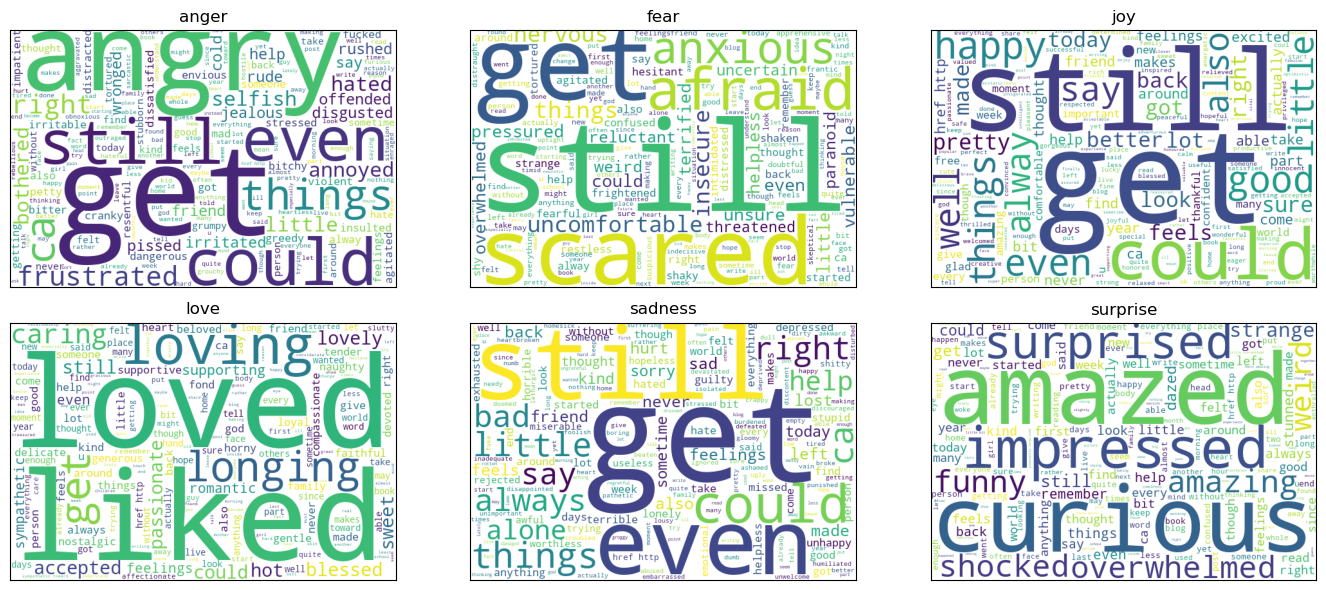

In [ ]:
fig, axs = plt.subplots(figsize= (14,6), ncols = 3, nrows= 2)

wc_generator = WordCloud(width= 600, height= 400, background_color ='white', stopwords= stop_words)

i = j = 0

for ee in emotions:
    # create dictionary of frequencies of words
    tmp_data = data.query(f"label == '{ee}'")['process_text']
    # remove any words that have a frequency of more than 5000
    tmp_dict = wc_generator.process_text(" ".join(tmp_data))
    tmp_dict = {key:val for key, val in tmp_dict.items() if val < 5000 }
    
    wordcloud = wc_generator.generate_from_frequencies(tmp_dict)
    axs[i,j].imshow(wordcloud)
    axs[i,j].set_title(ee)
    axs[i,j].get_yaxis().set_visible(False)
    axs[i,j].get_xaxis().set_visible(False)

    # increment column number
    j += 1

    # if more than 1 column, increase the row number
    if j == 3:
        i += 1
        j = 0


plt.tight_layout();
# fig.savefig("images/wordclouds.png")

## TF IDF Vectorization

In [ ]:
class DenseTransformer(TransformerMixin):
    def transform(self, X, y=None, **fit_params):
        return X.toarray()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [ ]:
stop_words.remove('ca')
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(min_df = 0.01, max_df= 0.95, stop_words= stop_words, ngram_range= (1,3))),
    ('dense', DenseTransformer()),
    ('knn', KNeighborsClassifier())
])
params = {'knn__n_neighbors': range(5,10,5),
          'tfidf__min_df': [0.01, 0.02, 0.05],
          'tfidf__max_df': [0.9, 0.95, 0.99]}
pipe_grid = GridSearchCV(pipe, param_grid= params, cv= 5)
pipe_grid.fit(data['process_text'], data['label'])

print(pipe_grid.best_params_)
model = pipe_grid.best_estimator_

c:\Users\garim\anaconda3\envs\github\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca'] not in stop_words.
  warnings.warn(
c:\Users\garim\anaconda3\envs\github\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca'] not in stop_words.
  warnings.warn(
c:\Users\garim\anaconda3\envs\github\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca'] not in stop_words.
  warnings.warn(
c:\Users\garim\anaconda3\envs\github\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca'] not in stop_word

{'knn__n_neighbors': 5}


In [ ]:
preds = model.predict(data['process_text'])

In [ ]:
X_test = data.head(100).copy()
X_test['pred_label'] = model.predict(X_test['process_text'])
X_test

,text,label,process_text,pred_label
0,i usually wear my hair in a twist out and when...,joy,i usually wear my hair in a twist out and when...,joy
1,i feel so irritated and rejected by it or is g...,anger,i feel so irritated and rejected by it or is g...,joy
2,i can feel it disturbed within me,sadness,i can feel it disturbed within me,joy
3,im talking about down right i feel like slappi...,anger,i m talking about down right i feel like slapp...,anger
4,i almost feel like im messing with a precious ...,joy,i almost feel like i m messing with a precious...,joy
...,...,...,...,...
995,i feel about my relationships romantic work fa...,love,i feel about my relationships romantic work fa...,joy
996,i were feeling a bit weepy,sadness,i were feeling a bit weepy,sadness
997,i feel said he art poetry target blank img src...,sadness,i feel said he art poetry target blank img src...,joy
998,i feel privileged,joy,i feel privileged,joy
